In [1]:
!pip install haversine
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 7.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 5.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 5.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.4 MB/s eta 0:00:00a 0:00:01


In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import haversine as hs
from haversine import Unit
import geopandas as gpd
from sklearn.covariance import GraphicalLassoCV, empirical_covariance
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
import warnings

warnings.filterwarnings('ignore')

In [50]:
# Function to plot nodes in the geographical position
def same_position_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))  
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

In [56]:
# load dataset with simulated acoustic structures
df = pd.read_excel(r'/Users/mariajoseguerrero/Documents/Universidad/PhD/Analisis KALE/Toy Problem/Soundscape_simulation.xlsx')
df

,sitio/sonotipo,latitude,longitude,habitat,1,2,3,4,5,6,7,8,9,10,total
0,0,7.36733,-73.86392,3,12,15,13,10,14,13,16,10,18,9,130
1,1,7.35697,-73.84627,1,7,4,6,10,25,0,10,15,0,15,92
2,2,7.36233,-73.85412,3,13,14,0,10,13,14,16,13,18,10,121
3,3,7.35610,-73.85893,2,11,13,0,8,9,15,7,8,12,9,92
4,4,7.35659,-73.85120,3,14,16,12,10,13,12,15,10,17,8,127
5,5,7.35329,-73.85260,4,1,3,0,6,0,7,8,3,0,9,37
6,6,7.36832,-73.86041,2,10,13,0,9,10,15,7,7,13,8,92
7,7,7.36238,-73.84993,3,26,28,0,20,26,28,32,26,36,20,242
8,8,7.37197,-73.86410,5,60,30,20,0,35,55,34,56,34,0,324
9,9,7.36765,-73.85181,3,52,56,0,40,52,56,64,52,72,40,484


In [11]:
# row sites - columns sonotypes
df_short=df.iloc[:,4:-1]
df_short

,1,2,3,4,5,6,7,8,9,10
0,12,15,13,10,14,13,16,10,18,9
1,7,4,6,10,25,0,10,15,0,15
2,13,14,0,10,13,14,16,13,18,10
3,11,13,0,8,9,15,7,8,12,9
4,14,16,12,10,13,12,15,10,17,8
5,1,3,0,6,0,7,8,3,0,9
6,10,13,0,9,10,15,7,7,13,8
7,26,28,0,20,26,28,32,26,36,20
8,60,30,20,0,35,55,34,56,34,0
9,52,56,0,40,52,56,64,52,72,40


In [13]:
# sites information
df_info=df.iloc[:,0:4]
df_info

,sitio/sonotipo,latitude,longitude,habitat
0,0,7.36733,-73.86392,3
1,1,7.35697,-73.84627,1
2,2,7.36233,-73.85412,3
3,3,7.35610,-73.85893,2
4,4,7.35659,-73.85120,3
5,5,7.35329,-73.85260,4
6,6,7.36832,-73.86041,2
7,7,7.36238,-73.84993,3
8,8,7.37197,-73.86410,5
9,9,7.36765,-73.85181,3


# Ground truth 

Adjacency of the expected graph

In [40]:
data=[[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0.5, 0, 0, 0.5, 1, 0, 0.5, 0],
        [0, 0, 0.5, 0, 0, 0, 2, 0, 0, 0, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0.5, 2, 0, 0, 0, 0, 0, 0, 0.3],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0]]

adj_matrix=pd.DataFrame(data)
adj_matrix

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,2,0,0.0,0,0,0.0,0.0
1,0,0,0.0,0.0,0,0,0.0,0,0,0.0,0.0
2,0,0,0.0,0.5,0,0,0.5,1,0,0.5,0.0
3,0,0,0.5,0.0,0,0,2.0,0,0,0.0,0.0
4,2,0,0.0,0.0,0,0,0.0,0,0,0.0,0.0
5,0,0,0.0,0.0,0,0,0.0,0,0,0.0,0.0
6,0,0,0.5,2.0,0,0,0.0,0,0,0.0,0.3
7,0,0,1.0,0.0,0,0,0.0,0,0,1.0,0.0
8,0,0,0.0,0.0,0,0,0.0,0,0,0.0,0.0
9,0,0,1.0,0.0,0,0,0.0,1,0,0.0,0.0


In [146]:
matrix=np.array(adj_matrix)
# change a binary matrix for evaluation metrics 
binary_matrix = (matrix != 0).astype(int)
binary_matrix

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

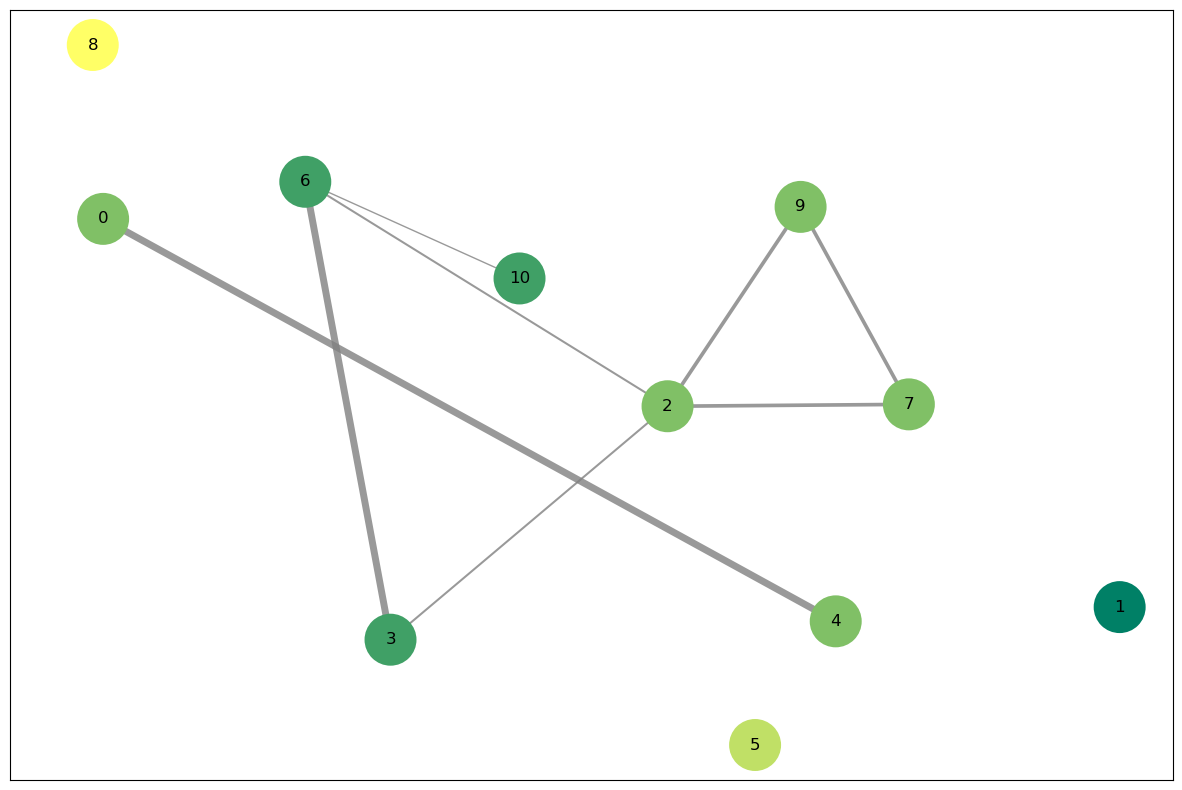

In [63]:
# Plot the ground truth graph
G_ref = nx.from_pandas_adjacency(adj_matrix)
coordinates=same_position_data(df_info)
coordinates=coordinates[G.nodes]
colores=df_info.habitat.values[G.nodes]
positions = dict(zip(G, coordinates))

edge_weights = [abs(G_ref[u][v]['weight']) for u, v in G.edges()]

plt.figure(figsize=(15,10))

node_size = 1400
node_color = colores
node_border_color = 'white'
node_border_width = 0
node_labels = {node: node for node in G.nodes()}

nx.draw_networkx_nodes(G_ref, positions, nodelist=G.nodes(), node_size=node_size, node_color=node_color,
                       linewidths=node_border_width, edgecolors=node_border_color, cmap="summer")
nx.draw_networkx_labels(G_ref, positions, labels=node_labels, font_color='black')

min_width = 1 
max_width = 5  
scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights] 

nx.draw_networkx_edges(G_ref, positions, width=scaled_widths, edge_color="grey", alpha=0.8)


# Graphical Lasso

Using the simulated data 

In [15]:
df_norm = (df_short - df_short.min()) / (df_short.max() - df_short.min())
df_norm

,1,2,3,4,5,6,7,8,9,10
0,0.200000,0.226415,0.65,0.250,0.269231,0.232143,0.157895,0.132075,0.250000,0.225
1,0.116667,0.018868,0.30,0.250,0.480769,0.000000,0.052632,0.226415,0.000000,0.375
2,0.216667,0.207547,0.00,0.250,0.250000,0.250000,0.157895,0.188679,0.250000,0.250
3,0.183333,0.188679,0.00,0.200,0.173077,0.267857,0.000000,0.094340,0.166667,0.225
4,0.233333,0.245283,0.60,0.250,0.250000,0.214286,0.140351,0.132075,0.236111,0.200
5,0.016667,0.000000,0.00,0.150,0.000000,0.125000,0.017544,0.000000,0.000000,0.225
6,0.166667,0.188679,0.00,0.225,0.192308,0.267857,0.000000,0.075472,0.180556,0.200
7,0.433333,0.471698,0.00,0.500,0.500000,0.500000,0.438596,0.433962,0.500000,0.500
8,1.000000,0.509434,1.00,0.000,0.673077,0.982143,0.473684,1.000000,0.472222,0.000
9,0.866667,1.000000,0.00,1.000,1.000000,1.000000,1.000000,0.924528,1.000000,1.000


In [17]:
info=df_norm
info

,1,2,3,4,5,6,7,8,9,10
0,0.200000,0.226415,0.65,0.250,0.269231,0.232143,0.157895,0.132075,0.250000,0.225
1,0.116667,0.018868,0.30,0.250,0.480769,0.000000,0.052632,0.226415,0.000000,0.375
2,0.216667,0.207547,0.00,0.250,0.250000,0.250000,0.157895,0.188679,0.250000,0.250
3,0.183333,0.188679,0.00,0.200,0.173077,0.267857,0.000000,0.094340,0.166667,0.225
4,0.233333,0.245283,0.60,0.250,0.250000,0.214286,0.140351,0.132075,0.236111,0.200
5,0.016667,0.000000,0.00,0.150,0.000000,0.125000,0.017544,0.000000,0.000000,0.225
6,0.166667,0.188679,0.00,0.225,0.192308,0.267857,0.000000,0.075472,0.180556,0.200
7,0.433333,0.471698,0.00,0.500,0.500000,0.500000,0.438596,0.433962,0.500000,0.500
8,1.000000,0.509434,1.00,0.000,0.673077,0.982143,0.473684,1.000000,0.472222,0.000
9,0.866667,1.000000,0.00,1.000,1.000000,1.000000,1.000000,0.924528,1.000000,1.000


In [119]:
datos=np.array(df_norm)
datos2=np.transpose(datos) 
datos2 /= datos2.std(axis=0)

In [23]:
edge_model = covariance.GraphicalLassoCV(cv=5, max_iter=10000,verbose=True, assume_centered=True)
edge_model.fit(datos2)

[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   1s
[GraphicalLassoCV] Done refinement  3 out of 4:   2s
[GraphicalLassoCV] Done refinement  4 out of 4:   4s


GraphicalLassoCV(assume_centered=True, cv=5, max_iter=10000, verbose=True)

In [25]:
p = np.around(edge_model.precision_, decimals=3) # precision matrix
p = pd.DataFrame(p)
A= np.around(edge_model.covariance_, decimals=3) # covariance
A= pd.DataFrame(A)

In [169]:
def plot_network(matrix, threshold, same_position_data_func, df_info):
    # Prepare the matrix for network illustration
    links = matrix.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']
    links2 = matrix.stack().reset_index()
    links2.columns = ['var1', 'var2', 'value']

    links = links.loc[(abs(links['value']) >= threshold) & (links['var1'] != links['var2'])]
    links2 = links2.loc[(links2['var1'] != links2['var2'])]

    # Create graph
    G = nx.from_pandas_edgelist(links, 'var1', 'var2', edge_attr='value', create_using=nx.Graph())

    all_nodes = pd.Series(pd.concat([links2['var1'], links2['var2']])).unique()

    # Create a complete graph with all nodes
    G_complete = nx.complete_graph(all_nodes)

    # Nodes position and colors
    coordinates = same_position_data_func(df_info)
    coordinates = coordinates[G_complete.nodes]
    colores = df_info.habitat.values[G_complete.nodes]
    positions = dict(zip(G_complete.nodes, coordinates))

    # Edge weights
    edge_weights = [abs(G[u][v]['value']) for u, v in G.edges()]

    plt.figure(figsize=(15, 10))

    node_size = 1400
    node_color = colores
    node_border_color = 'white'
    node_border_width = 0
    node_labels = {node: node for node in G_complete.nodes()}
    nx.draw_networkx_nodes(G_complete, positions, nodelist=G_complete.nodes(), node_size=node_size, node_color=node_color,
                           linewidths=node_border_width, edgecolors=node_border_color, cmap="summer")
    nx.draw_networkx_labels(G_complete, positions, labels=node_labels, font_color='black')

    min_width = 1
    max_width = 5
    scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights]

    # Plot final graph
    nx.draw_networkx_edges(G, positions, width=scaled_widths, edge_color="darkblue", alpha=0.8)

    plt.show()
    return G, G_complete


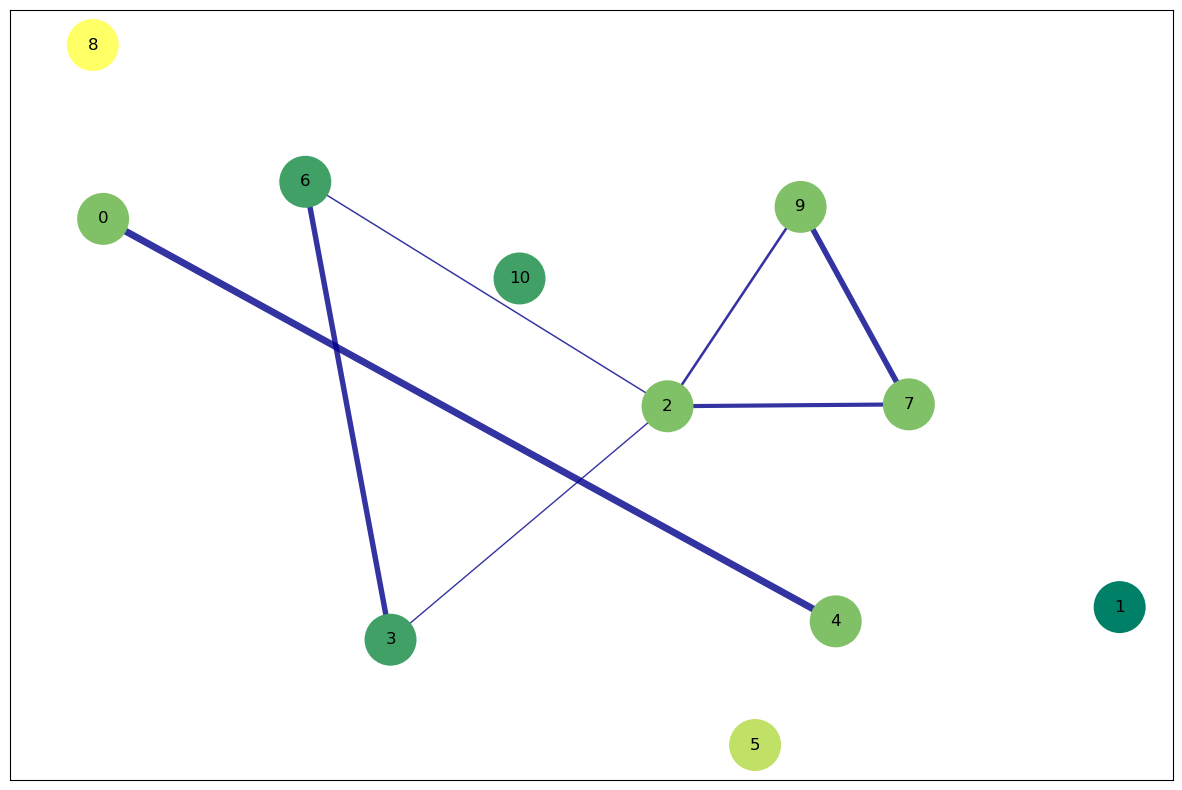

In [171]:
G, G_complete=plot_network(p, 0.5, same_position_data, df_info)

In [173]:
# Graphical Lasso adjacency matrix generation
adj_matrix_Glasso = np.zeros((len(G_complete), len(G_complete)))

enlaces = G.edges

for enlace in enlaces:
    fila, columna = enlace
    adj_matrix_Glasso[fila, columna] = 1
    adj_matrix_Glasso[columna, fila] = 1

print(adj_matrix_Glasso)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


confusion matrix between ground truth and Glasso

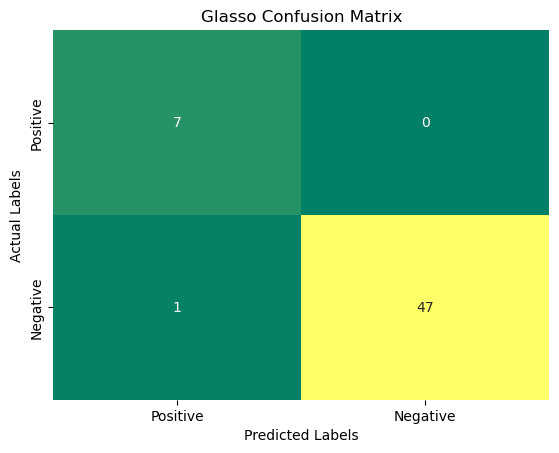

(7, 47, 0, 1, 0.9818181818181818)

In [176]:
# confusion matrix - Ground truth and Glasso
mask = np.triu(np.ones_like(binary_matrix, dtype=bool), k=1)

TP = np.sum((binary_matrix == 1) & (adj_matrix_Glasso == 1) & mask)
TN = np.sum((binary_matrix == 0) & (adj_matrix_Glasso== 0) & mask)
FP = np.sum((binary_matrix == 0) & (adj_matrix_Glasso == 1) & mask)
FN = np.sum((binary_matrix == 1) & (adj_matrix_Glasso== 0) & mask)

conf_matrix = np.array([[TP, FP], [FN, TN]])

accuracy = (TP + TN) / (TP + TN + FP + FN)

plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="summer", cbar=False,
            xticklabels=["Positive", "Negative"],
            yticklabels=["Positive", "Negative"])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Glasso Confusion Matrix")
plt.show()

TP, TN, FP, FN, accuracy

# Bray Curtis 

Using the simulated data

In [87]:
data = df_norm
data

,1,2,3,4,5,6,7,8,9,10
0,0.200000,0.226415,0.65,0.250,0.269231,0.232143,0.157895,0.132075,0.250000,0.225
1,0.116667,0.018868,0.30,0.250,0.480769,0.000000,0.052632,0.226415,0.000000,0.375
2,0.216667,0.207547,0.00,0.250,0.250000,0.250000,0.157895,0.188679,0.250000,0.250
3,0.183333,0.188679,0.00,0.200,0.173077,0.267857,0.000000,0.094340,0.166667,0.225
4,0.233333,0.245283,0.60,0.250,0.250000,0.214286,0.140351,0.132075,0.236111,0.200
5,0.016667,0.000000,0.00,0.150,0.000000,0.125000,0.017544,0.000000,0.000000,0.225
6,0.166667,0.188679,0.00,0.225,0.192308,0.267857,0.000000,0.075472,0.180556,0.200
7,0.433333,0.471698,0.00,0.500,0.500000,0.500000,0.438596,0.433962,0.500000,0.500
8,1.000000,0.509434,1.00,0.000,0.673077,0.982143,0.473684,1.000000,0.472222,0.000
9,0.866667,1.000000,0.00,1.000,1.000000,1.000000,1.000000,0.924528,1.000000,1.000


In [89]:
#  Bray-Curtis distance
distances = pdist(data, metric='braycurtis')
distance_matrix = squareform(distances)
matriz_d=pd.DataFrame(distance_matrix)
matriz_d

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.381628,0.174318,0.284779,0.038421,0.658321,0.285538,0.434451,0.513345,0.658685,0.502697
1,0.381628,0.000000,0.413275,0.501130,0.389030,0.652410,0.500548,0.501356,0.698559,0.713454,0.474127
2,0.174318,0.413275,0.000000,0.158406,0.183130,0.581831,0.159202,0.358315,0.625944,0.626195,0.415233
3,0.284779,0.501130,0.158406,0.000000,0.289879,0.491761,0.039611,0.481021,0.717734,0.708663,0.548651
4,0.038421,0.389030,0.183130,0.289879,0.000000,0.664513,0.278152,0.439023,0.523586,0.663243,0.491944
5,0.658321,0.652410,0.581831,0.491761,0.664513,0.000000,0.515778,0.777958,0.952079,0.885429,0.846901
6,0.285538,0.500548,0.159202,0.039611,0.278152,0.515778,0.000000,0.481640,0.718279,0.709064,0.532207
7,0.434451,0.501356,0.358315,0.481021,0.439023,0.777958,0.481640,0.000000,0.374323,0.345373,0.442190
8,0.513345,0.698559,0.625944,0.717734,0.523586,0.952079,0.718279,0.374323,0.000000,0.342124,0.689767
9,0.658685,0.713454,0.626195,0.708663,0.663243,0.885429,0.709064,0.345373,0.342124,0.000000,0.683221


In [93]:
# took inverse values to obtain a similar scale as Glasso
inverse=1-matriz_d
diagonal=inverse.values
np.fill_diagonal(diagonal,0)
Bray=pd.DataFrame(diagonal)
Bray

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.618372,0.825682,0.715221,0.961579,0.341679,0.714462,0.565549,0.486655,0.341315,0.497303
1,0.618372,0.000000,0.586725,0.498870,0.610970,0.347590,0.499452,0.498644,0.301441,0.286546,0.525873
2,0.825682,0.586725,0.000000,0.841594,0.816870,0.418169,0.840798,0.641685,0.374056,0.373805,0.584767
3,0.715221,0.498870,0.841594,0.000000,0.710121,0.508239,0.960389,0.518979,0.282266,0.291337,0.451349
4,0.961579,0.610970,0.816870,0.710121,0.000000,0.335487,0.721848,0.560977,0.476414,0.336757,0.508056
5,0.341679,0.347590,0.418169,0.508239,0.335487,0.000000,0.484222,0.222042,0.047921,0.114571,0.153099
6,0.714462,0.499452,0.840798,0.960389,0.721848,0.484222,0.000000,0.518360,0.281721,0.290936,0.467793
7,0.565549,0.498644,0.641685,0.518979,0.560977,0.222042,0.518360,0.000000,0.625677,0.654627,0.557810
8,0.486655,0.301441,0.374056,0.282266,0.476414,0.047921,0.281721,0.625677,0.000000,0.657876,0.310233
9,0.341315,0.286546,0.373805,0.291337,0.336757,0.114571,0.290936,0.654627,0.657876,0.000000,0.316779


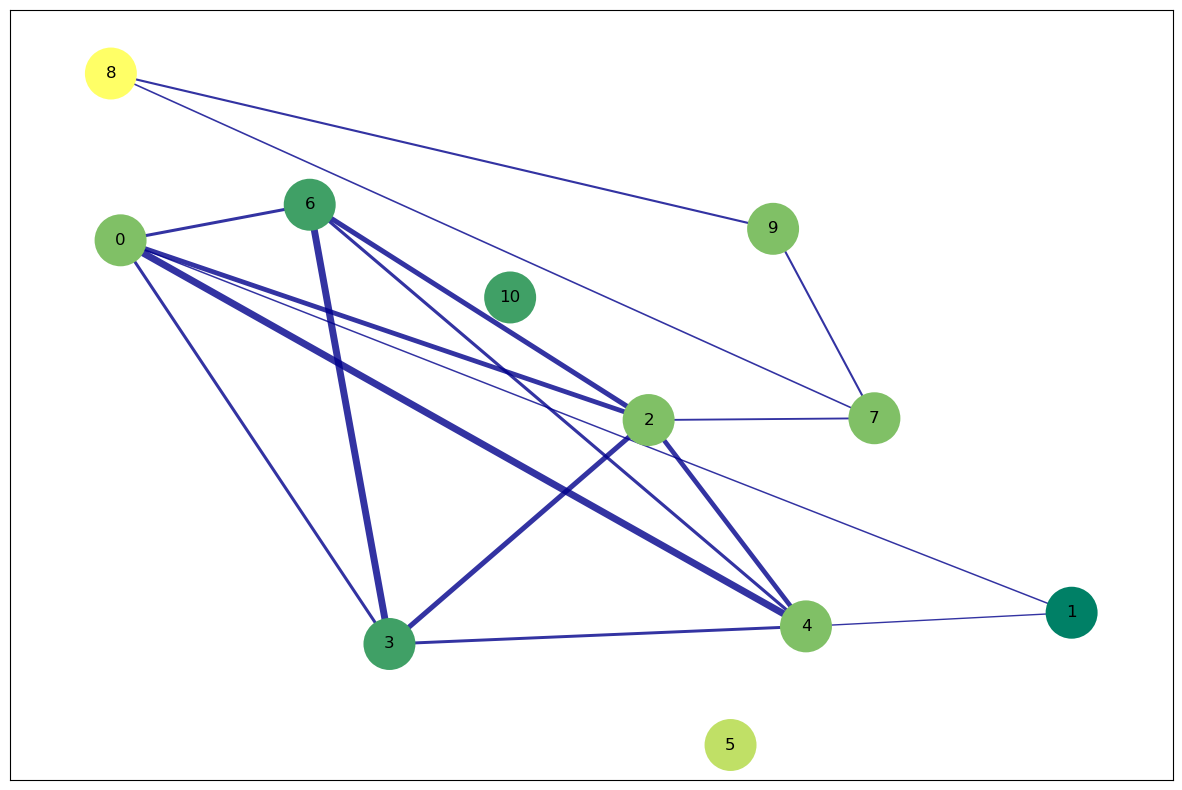

In [162]:
G_bray, G_bray_complete=plot_network(Bray, 0.6, same_position_data, df_info)

In [164]:
# Bray Curtis adjacency matrix generation
adj_matrix_Bray = np.zeros((len(G_bray_complete), len(G_bray_complete)))

enlaces2 = G_bray.edges

for enlace in enlaces2:
    fila, columna = enlace
    adj_matrix_Bray[fila, columna] = 1
    adj_matrix_Bray[columna, fila] = 1

print(adj_matrix_Bray)

[[0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


confusion matrix between ground truth and Bray-Curtis

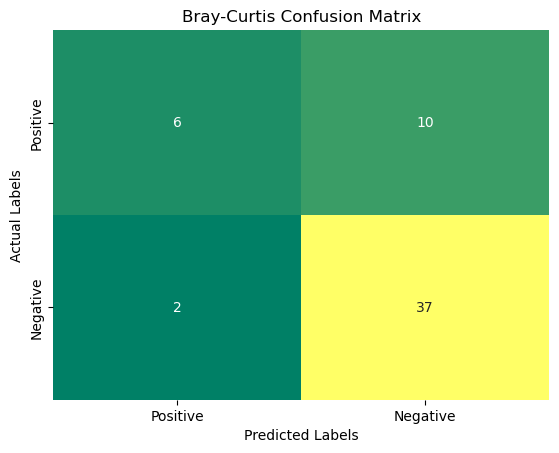

(6, 37, 10, 2, 0.7818181818181819)

In [166]:
# confusion matrix - Ground Truth and Bray-Curtis

mask = np.triu(np.ones_like(binary_matrix, dtype=bool), k=1)

TP = np.sum((binary_matrix == 1) & (adj_matrix_Bray == 1) & mask)
TN = np.sum((binary_matrix == 0) & (adj_matrix_Bray== 0) & mask)
FP = np.sum((binary_matrix == 0) & (adj_matrix_Bray == 1) & mask)
FN = np.sum((binary_matrix == 1) & (adj_matrix_Bray == 0) & mask)

conf_matrix = np.array([[TP, FP], [FN, TN]])

accuracy = (TP + TN) / (TP + TN + FP + FN)

plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="summer", cbar=False,
            xticklabels=["Positive", "Negative"],
            yticklabels=["Positive", "Negative"])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Bray-Curtis Confusion Matrix")
plt.show()

TP, TN, FP, FN, accuracy